In [32]:
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import RobustScaler,StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV,TimeSeriesSplit

# Data Loading and Preprocessing

### Loading

In [33]:
def draw_plot(data,ax,xlabel,title):
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.plot(data)
    return None

def draw_hist(data,ax,xlabel,title):
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.hist(data)
    return None

In [34]:
df = pd.read_csv("./retail_data.csv",sep=',')
print(df.info(memory_usage="deep"))
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      541909 non-null int64
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null object
UnitPrice      541909 non-null float64
CustomerID     406829 non-null float64
Country        541909 non-null object
dtypes: float64(2), int64(2), object(4)
memory usage: 167.4 MB
None


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,1,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,5504.0,United Kingdom
1,1,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,5504.0,United Kingdom
2,1,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,5504.0,United Kingdom
3,1,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,5504.0,United Kingdom
4,1,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,5504.0,United Kingdom


__First impression:__
<br>
1) Data are messy and there are some missing values in "Description" and "CustumerID".
<br>
2) There is a chance to reduce memory usage by changing features types.

### Cleaning and Visualisation

In [35]:
df["InvoiceDate"]= pd.to_datetime(df["InvoiceDate"]) #object to DataTime64 
df[["StockCode","Country"]]=df[["StockCode","Country"]].astype("category")
df[["InvoiceNo","Quantity"]]=df[["InvoiceNo","Quantity"]].astype("int")
df.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      541909 non-null int32
StockCode      541909 non-null category
Description    540455 non-null object
Quantity       541909 non-null int32
InvoiceDate    541909 non-null datetime64[ns]
UnitPrice      541909 non-null float64
CustomerID     406829 non-null float64
Country        541909 non-null category
dtypes: category(2), datetime64[ns](1), float64(2), int32(2), object(1)
memory usage: 61.6 MB


###### Changes:
1)"InvoiceDate" was changed from object to datetime64, so values can be used in a very efficient way.
<br>
2)"InvoiceNo" and "Quantity" was changed to integer.
<br>
For now, it is impossible to change the type of columns with NaN's.
<br>
__Overall memory usage reduced by 63%__

In [36]:
df.describe(include="all") #Statistical parameters of the each feature - all columns

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
count,541909.000000,541909,540455,541909.000000,541909,541909.000000,406829.000000,541909
unique,NaN,4070,4223,NaN,23260,NaN,NaN,38
top,NaN,85123A,WHITE HANGING HEART T-LIGHT HOLDER,NaN,2011-10-31 14:41:00,NaN,NaN,United Kingdom
freq,NaN,2313,2369,NaN,1114,NaN,NaN,495478
first,NaN,NaN,NaN,NaN,2010-12-01 08:26:00,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,2011-12-09 12:50:00,NaN,NaN,NaN
mean,23582.967325,NaN,NaN,9.552250,NaN,4.611114,2941.690570,NaN
std,13421.287454,NaN,NaN,218.081158,NaN,96.759853,1713.600303,NaN
min,1.000000,NaN,NaN,-80995.000000,NaN,-11062.060000,0.000000,NaN
25%,11532.000000,NaN,NaN,1.000000,NaN,1.250000,1607.000000,NaN


##### Observations
We can observe some alarming signals. For example negative "Quantity" and "UnitPrice". Moreover, there are probably some outliers. We need to handle it. Max and min in "Quantity" and "UnitPrice" are far beyond __3*std__. Data starts from 2010-12-01 08:26:00 and ends at 2011-12-09 12:50:00. There are 4070 unique stock codes and their average frequency is 2313. More unique "Descriptions" than "StockCodes" suggest that for one Stock code can exist several descriptions. At 2011-10-31 14:41:00 is someone order with the most items.
##### Our goal is to bild model that will predict when given  item will be ordered again. 
<br>
To be more specific, by "order" I mean rows witch represent an only act of buying. Therefore the price and quantity of "order" have to be a positive number.
If there are some other transactions like fees, credit debts, etc. I will remove them. Rows with zero or negative "Quantity" or "UnitPrice" will be removed also. They probably represent returns and gifts.

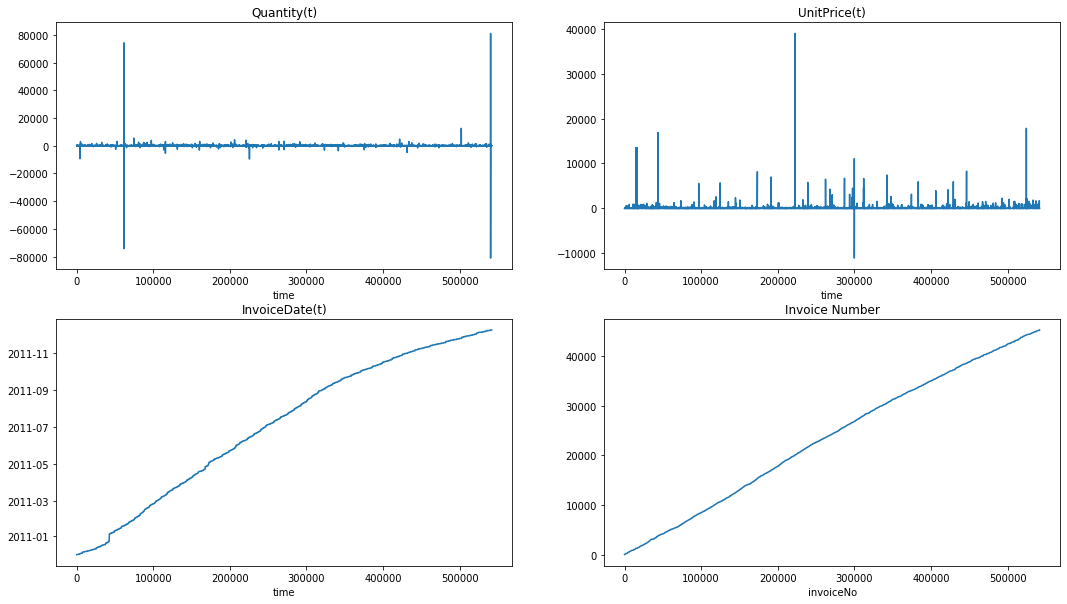

In [37]:
#Let's see how raw data looks like.
fig, ((bx1, bx2), (bx3, bx4))= plt.subplots(2, 2,figsize=(18,10))

draw_plot(df.Quantity,bx1,"time",'Quantity(t)')
draw_plot(df.UnitPrice,bx2,"time",'UnitPrice(t)')
draw_plot(df.InvoiceDate,bx3,"time",'InvoiceDate(t)')
draw_plot(df.InvoiceNo,bx4,"invoiceNo",'Invoice Number')

plt.show()

##### Observations
The highest outliers in Quantity are horizontally symmetrical. It can be a cancellation of the order. There is one easily seen outlier in price with a negative price. We don't have information about currency. I assume that all transactions were made in the same money. InvoiceDate is quite linear but it is more falt in the end. It suggests that the shop had more orders at the end of a year. Linear invoiceNo it's perfectly normal.

In [38]:
fltr=df["Description"].isna()
df[fltr].head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,50,22139,NaN,56,2010-12-01 11:52:00,0.0,NaN,United Kingdom
1970,181,21134,NaN,1,2010-12-01 14:32:00,0.0,NaN,United Kingdom
1971,182,22145,NaN,1,2010-12-01 14:33:00,0.0,NaN,United Kingdom


We see that NaNs in "Description" and "CustomerID" are connected with zero at "UnitPrice". I will check, how many rows like that do we have. Also, we can see that there are some characters in StocCode.

In [39]:
fltr=df["UnitPrice"]<=0 # second filter
print("Number of  0 prices and below: "+str(len(df[fltr])))
print("Percentage of 0 prices and below: "+str(len(df[fltr])*100/len(df))+"%")

Number of  0 prices and below: 2517
Percentage of 0 prices and below: 0.46446912673530055%


In [40]:
df.drop(df[fltr].index,inplace=True)
df.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 539392 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      539392 non-null int32
StockCode      539392 non-null category
Description    539392 non-null object
Quantity       539392 non-null int32
InvoiceDate    539392 non-null datetime64[ns]
UnitPrice      539392 non-null float64
CustomerID     406789 non-null float64
Country        539392 non-null category
dtypes: category(2), datetime64[ns](1), float64(2), int32(2), object(1)
memory usage: 65.6 MB


Great! Problem with NaN's in "Description" is solved.

##### What is the time distribution of all transactions?

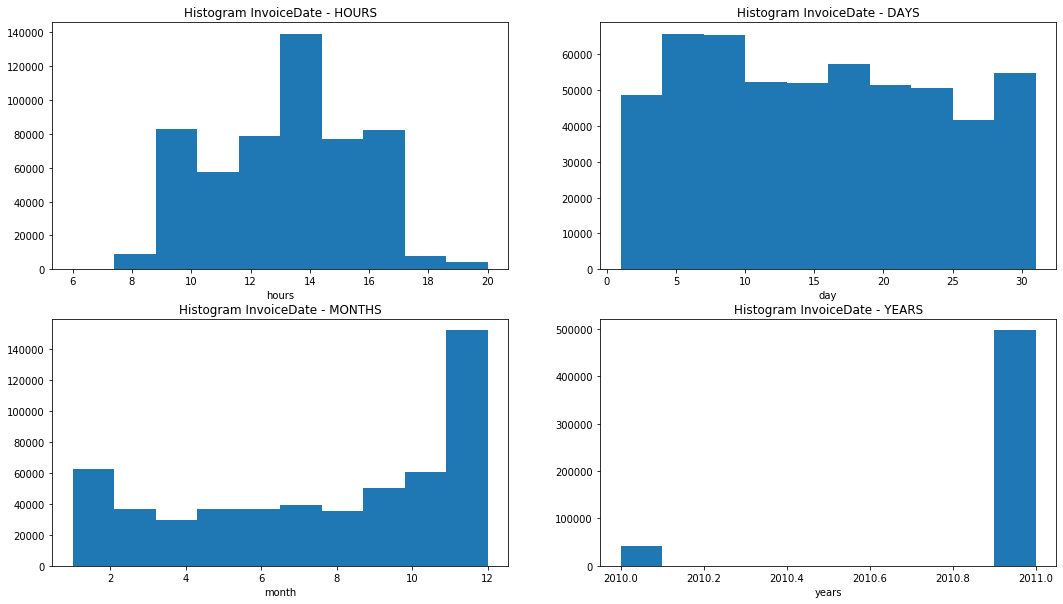

In [41]:
fig, ((ax1, ax2), (ax3, ax4))= plt.subplots(2, 2,figsize=(18,10))

draw_hist(df["InvoiceDate"].dt.hour,ax1,"hours",'Histogram InvoiceDate - HOURS')
draw_hist(df["InvoiceDate"].dt.day,ax2,"day",'Histogram InvoiceDate - DAYS')
draw_hist(df["InvoiceDate"].dt.month,ax3,"month",'Histogram InvoiceDate - MONTHS')
draw_hist(df["InvoiceDate"].dt.year,ax4,"years",'Histogram InvoiceDate - YEARS')

plt.show()

The peak of transactions occurred about 1 pm. Second, after 8 am.It looks like people buy more at the beginning of the month but peak occurs on the 30th. Moreover, the retailer sells the most in November. What, is in accord with intuition.

In [42]:
#Filtering unsual StockCode
index_binary = df['StockCode'].str[0:5].str.isnumeric()
print("Number of unsual entries: "+str(len(df[~index_binary])))
df[~index_binary]

Number of unsual entries: 2963


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
45,6,POST,POSTAGE,3,2010-12-01 08:45:00,18.00,237.0,France
141,15,D,Discount,-1,2010-12-01 09:41:00,27.50,2181.0,United Kingdom
386,39,POST,POSTAGE,1,2010-12-01 11:27:00,15.00,445.0,Netherlands
1123,163,POST,POSTAGE,1,2010-12-01 13:04:00,18.00,316.0,Germany
1423,176,C2,CARRIAGE,1,2010-12-01 14:05:00,50.00,2565.0,EIRE
...,...,...,...,...,...,...,...,...
541540,45134,DOT,DOTCOM POSTAGE,1,2011-12-09 10:26:00,1714.17,NaN,United Kingdom
541541,45135,M,Manual,-1,2011-12-09 10:28:00,224.69,3152.0,United Kingdom
541730,45206,POST,POSTAGE,1,2011-12-09 11:59:00,18.00,316.0,Germany
541767,45210,POST,POSTAGE,2,2011-12-09 12:09:00,18.00,180.0,Germany


It looks like that rows with those descriptions in "StockCode" represent some unusual entries like fees, vouchers, gifts etc. 
We can safely remove those rows to make data cleaner.

In [43]:
index=df[~index_binary].index
df.drop(index,inplace=True)
print("Shape of DataFrame after droping: "+str(df.shape))

Shape of DataFrame after droping: (536429, 8)


In [44]:
#chacking for duplicate rows and removing them
print('Duplicate rows: '+str(df.duplicated().sum()))
df.drop_duplicates(inplace = True)
print("Shape of DataFrame after droping duplicates:"+str(df.shape))

Duplicate rows: 5257
Shape of DataFrame after droping duplicates:(531172, 8)


In [45]:
# chacking the statistic after droping
df.describe()

,InvoiceNo,Quantity,UnitPrice,CustomerID
count,531172.000000,531172.000000,531172.000000,399656.000000
mean,23581.734163,9.961487,3.292533,2942.781965
std,13414.915648,217.014514,4.512918,1710.791025
min,1.000000,-80995.000000,0.030000,0.000000
25%,11537.500000,1.000000,1.250000,1613.000000
50%,24241.000000,3.000000,2.080000,2806.000000
75%,35373.000000,10.000000,4.130000,4445.000000
max,45223.000000,80995.000000,649.500000,5941.000000


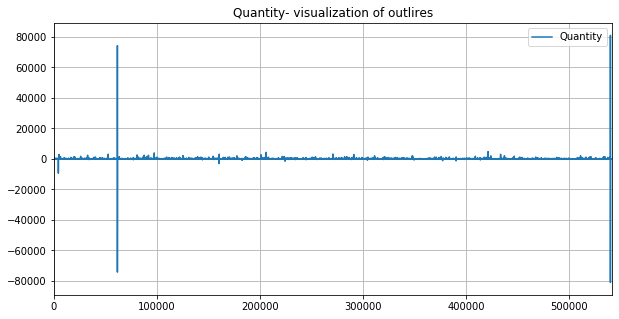

In [46]:
_=df["Quantity"].plot(figsize=(10,5),title="Quantity- visualization of outlires",
                      legend=True,grid=True)

In [47]:
#Droping Quantity<=0 and higher than 5000
fltr=(df["Quantity"]<=0) | (df["Quantity"]>5000)
index=df[fltr].index
df.drop(index,inplace=True)

In [48]:
na_index=df["CustomerID"].isna()
print("Number of Customers without ID: "+str(len(df[na_index])))
av_man=df[~na_index]["CustomerID"].groupby(df["CustomerID"]).transform("count").median()
print("Average freqency of Customer with ID "+str(av_man))

Number of Customers without ID: 131354
Average freqency of Customer with ID 197.0


Since our task is to predict time to next order we don't need full information about the customer. Moreover, other features of transaction looks fine. Most "no-name" Customers bought just one product at a relatively low price.Dropping 131388 samples (25%) would be a huge waste and could have a negative impact on training performance. 
Therethrough, I will assign some IDs. In order to have balanced data, I need to set N IDs where N *average_customer~130k.
<br>
average_customer = 200 => N ~750

In [49]:
def new_id(na_index,n=200):
    ids=int(len(df[na_index])/n)
    print("Number of new Customers: "+str(ids))
    IDs=[-1*(i%ids+1) for i in range(1,len(df[na_index])+1)]
    print(len(IDs))
    return IDs

new_vec= new_id(na_index,200)
index=df[na_index].index
df.loc[index,"CustomerID"]=np.array(new_vec)

print("NaN = "+str(df["CustomerID"].isna().sum()))

Number of new Customers: 656
131354
NaN = 0


In [50]:
df.describe()

,InvoiceNo,Quantity,UnitPrice,CustomerID
count,522502.000000,522502.000000,522502.000000,522502.000000
mean,23598.955390,10.346506,3.273900,2125.260814
std,13420.880261,37.855225,4.393156,2054.345105
min,1.000000,1.000000,0.040000,-656.000000
25%,11542.000000,1.000000,1.250000,-4.000000
50%,24325.000000,4.000000,2.080000,2021.000000
75%,35460.000000,12.000000,4.130000,3909.000000
max,45223.000000,4800.000000,649.500000,5941.000000


Great. Presented method works fine. After replacing all NaN's it is possible to change type of "Description" and"CustomerID.

In [51]:
df[["Description"]]=df[["Description"]].astype("category")
df[["CustomerID"]]=df[["CustomerID"]].astype("int")
print(df.info(memory_usage="deep"))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 522502 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      522502 non-null int32
StockCode      522502 non-null category
Description    522502 non-null category
Quantity       522502 non-null int32
InvoiceDate    522502 non-null datetime64[ns]
UnitPrice      522502 non-null float64
CustomerID     522502 non-null int32
Country        522502 non-null category
dtypes: category(3), datetime64[ns](1), float64(1), int32(3)
memory usage: 41.3 MB
None


In [52]:
#Final chack if there is no NaN's
df.isna().any()

InvoiceNo      False
StockCode      False
Description    False
Quantity       False
InvoiceDate    False
UnitPrice      False
CustomerID     False
Country        False
dtype: bool

__Done. There are no missing values. Finally, we achieved a reduction of the memory usage about 90%.__

Customer's country - UK vs ALL: 0.9164290280228592


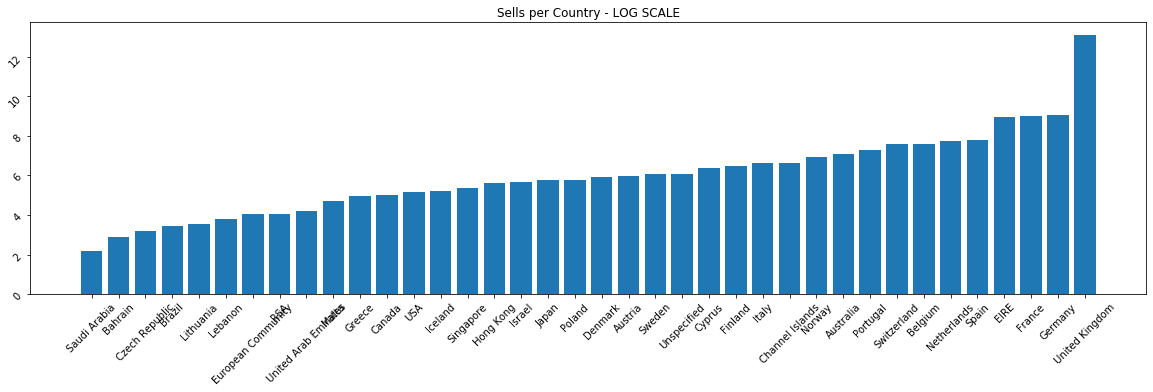

In [53]:
country=df.groupby("Country")["Country"].count()
country_sorted=country.sort_values()
fig, ax = plt.subplots(1,1, figsize=(20,5))
ax.bar(country_sorted.index,np.log(country_sorted))
ax.tick_params(labelrotation=45)
ax.set_title("Sells per Country - LOG SCALE")
print("Customer's country - UK vs ALL: "
      +str(country_sorted[-1]/sum(country_sorted)))

Most customers come from the UK (~90%). Maybe is it a good idea to make just two groups. The UK and the others.
To better visualisation of minorities, I used logscale.

In [54]:
#Droping dead categories
df[["StockCode","Description","Country"]]=df[["StockCode","Description","Country"]].astype("str")
df[["StockCode","Description","Country"]]=df[["StockCode","Description","Country"]].astype("category")
df.to_pickle("df_dirty")

In [55]:
#Saving data
#df=pd.read_pickle("df_dirty")

### Feature engineering

In [56]:
#Defining time paramiters
first_date =df["InvoiceDate"].min()
last_date=df["InvoiceDate"].max()
period = pd.Timedelta(last_date-first_date).days
print("First: "+str(first_date)
      +"\nLast "+str(last_date)
      +"\nPeriod: "+str(period))

First: 2010-12-01 08:26:00
Last 2011-12-09 12:50:00
Period: 373


##### Adding a new Features.

In [57]:
#Revenue
df["Price*Quantity"]=df["UnitPrice"]*df["Quantity"]

#Frequency of buying a given item
df["Freq_stock"] = df["StockCode"].groupby(df["StockCode"]).transform("count")

#Frequency of buying by a given customer
df["Freq_customer"]=df["CustomerID"].groupby(df["CustomerID"]).transform("count")

#Exploding InvoiceDate to 5 single ints
df["Year"] = df['InvoiceDate'].dt.year
df["Month"] = df['InvoiceDate'].dt.month
df["Day"] = df['InvoiceDate'].dt.day
df["Hour"] = df['InvoiceDate'].dt.hour
df["Minute"] = df['InvoiceDate'].dt.minute

# Just two country categories
df["Country"]=df["Country"].apply(lambda x:1 if x=="United Kingdom" else -1) # Two groups

#CAUTION!!
#It is convenient to have just one output variable. So, I decided that it will be a time
#to next order representing by a float number. 1 is one day. For example 3.5 means,
#that given item will be ordered on average by three and half of a day.
df["Time"]= df.groupby("StockCode")["InvoiceDate"].shift(periods=-1,fill_value=last_date)
temp=(df["Time"]-df["InvoiceDate"])
df["Time"]=temp.dt.days+temp.dt.seconds/86400

#Filling zeros by stock_frequency
index=df[df["Time"]==0.0].index
df.loc[index,"Time"]=df.loc[index,"Freq_stock"]

#Droping used columns
df.drop(columns=["InvoiceNo","StockCode","CustomerID","Description"],inplace=True)
df.to_pickle("df_cleaned")
df.head()

,Quantity,InvoiceDate,UnitPrice,Country,Price*Quantity,Freq_stock,Freq_customer,Year,Month,Day,Hour,Minute,Time
0,6,2010-12-01 08:26:00,2.55,1,15.30,2253,297,2010,12,1,8,26,0.025
1,6,2010-12-01 08:26:00,3.39,1,20.34,340,297,2010,12,1,8,26,0.025
2,8,2010-12-01 08:26:00,2.75,1,22.00,286,297,2010,12,1,8,26,0.025
3,6,2010-12-01 08:26:00,3.39,1,20.34,466,297,2010,12,1,8,26,0.025
4,6,2010-12-01 08:26:00,3.39,1,20.34,438,297,2010,12,1,8,26,0.025


##### Features engineering and important decisions

It is convenient to have just one output variable. So, I decided that it will be a time for next orders representing by float number. 1 is one day. For example 3.5 means, that the given item will be ordered on average by three and half of a day.
This Model is a proof of concept, so it is simple. In the next iteration, other important features can be added to get better performance.
I will use it as a regressor random forest, so exploding a DataTime to 5 variables is probably a good idea.

# Target Variable Visual Analysis

In [58]:
df["Time"].describe()

count    522502.000000
mean          9.909360
std          83.081970
min           0.000694
25%           0.058333
50%           0.759028
75%           1.900000
max        2253.000000
Name: Time, dtype: float64

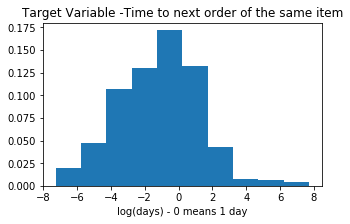

In [59]:
fig,ax= plt.subplots(1, 1,figsize=(5,3))
ax.hist(np.log(df["Time"]),density=True)
ax.set_title("Target Variable -Time to next order of the same item")
ax.set_xlabel("log(days) - 0 means 1 day")
plt.show()

Logscale was used to better visualisation. Negative values represent "Time" less than 1 (day), because of Log(1)=0
As we can see a majority of items have time to nex order smaller than one day. 

In [60]:
quantile=df["Time"].quantile(0.99)
print("99% of all samples are less than "+str(quantile))
index=df[df["Time"]>=quantile].index
print("1% of outliers: \n"+str(df.loc[index,"Time"]))

99% of all samples are less than 256.0
1% of outliers: 
107       373.13125
304       399.00000
556       333.00000
557       327.00000
559       430.00000
            ...    
541902    905.00000
541903    372.00000
541905    315.00000
541906    301.00000
541908    938.00000
Name: Time, Length: 5239, dtype: float64


In [61]:
df.drop(index,inplace=True) # dropping outliers

In [62]:
quantile=df["Time"].quantile(0.99)
print("After dropping 99% of samples are less then "+str(quantile))

After dropping 99% of samples are less then 43.16490277777784


In [63]:
df["Time"].describe()

count    517263.000000
mean          2.916643
std          13.872146
min           0.000694
25%           0.057639
50%           0.748611
75%           1.870833
max         255.998611
Name: Time, dtype: float64

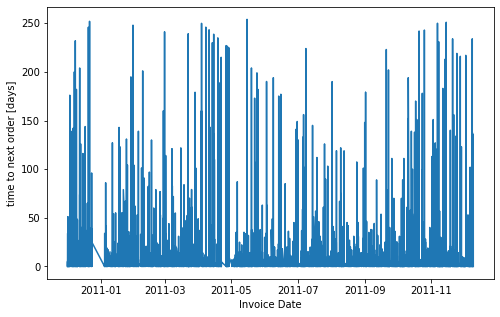

In [64]:
_,ax = plt.subplots(1,1,figsize=(8,5))
ax.plot(df["InvoiceDate"][::20],df["Time"][::20])
ax.set_xlabel("Invoice Date")
ax.set_ylabel("time to next order [days]")
ax.set_title=("Target Variable 5% of all observations")
plt.show()

##### Conclusion
Visualisation of Target[InvoiceDate]. Function looks fine. There is a gap just before 01.2011.
<br>
Shop sells more at the end of the year and this is what we see in visualisation. Moreover, there is visible kind of artificial linear pattern witch is form by "Time" peaks. In my opinion, it comes from a difference in sells from April till November. If we have a low season, in general, we have to wait for more for next orders.

# Modeling

##### Splitting DataSet

In [65]:
#df.to_pickle("df_cleaned")
df=pd.read_pickle("df_cleaned")

In [66]:
#Assign Y and X. Dropping unused further columns 
Y=np.array(df["Time"])
df.drop(columns=["Time","InvoiceDate"],inplace=True)
X=np.array(df)

In [67]:
#Dividing df to X and target variable Y
train_to_all=0.9 #Splitting_parameter

n=len(df)
ntrain=int(train_to_all*n)
print("Number of rows: "+str(len(df)))

Y_train=np.array(Y[:ntrain])#90% first - train
Y_val=np.array(Y[ntrain:]) #10% last -final validation

X_train=np.array(X[:ntrain]) #90% first - train
X_val=np.array(X[ntrain:])  #10% last -final validation

#Scaling
Scaler = RobustScaler()
X_train = Scaler.fit_transform(X_train)
X_val = Scaler.transform(X_val)

Number of rows: 522502


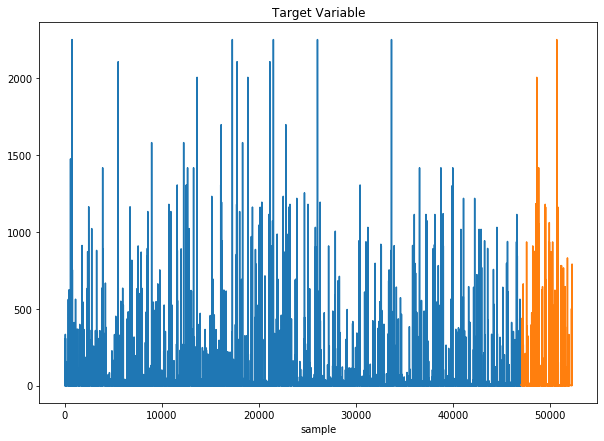

In [68]:
nsample=10
fig, ax = plt.subplots(figsize=(10,7))
vt=[None for t in Y_train] + [v for v in Y_val]
draw_plot(Y_train[::nsample],ax,"","")
draw_plot(vt[::nsample],ax,"sample","Target Variable")                      
plt.show()

### Random forests
##### RandomSearch preparation

In [69]:
from sklearn.metrics import make_scorer

In [105]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 3)]
# Number of features to consider at every split
max_features =  ["sqrt"]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(28, 62, num = 3)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2,4,8]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2,4]
# Method of selecting samples for training each tree
bootstrap = [True]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 1100, 2000], 'max_features': ['sqrt'], 'max_depth': [28, 45, 62, None], 'min_samples_split': [2, 4, 8], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True]}


In [108]:
#Initialization of estimator
MAE = make_scorer(mean_absolute_error,greater_is_better=False) #Loss
RF = RandomForestRegressor() #Initialization

#cross-validation is not good for time series. TimeSeriesSplit is better
my_cv = TimeSeriesSplit(n_splits=2).split(X_train)
RF_random=RandomizedSearchCV(RF, random_grid, n_iter=3,n_jobs=-1, cv=my_cv,scoring=MAE,
                             random_state=42,verbose=40,return_train_score=True)
RF_random.fit(X_train, Y_train)

Fitting 2 folds for each of 3 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done   2 out of   6 | elapsed:  5.5min remaining: 10.9min
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:  8.0min remaining:  8.0min
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed: 10.4min remaining:  5.2min
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed: 16.0min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed: 16.0min finished


RandomizedSearchCV(cv=<generator object TimeSeriesSplit.split at 0x0000026E2A5087C8>,
                   error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n...
                   iid='warn', n_iter=3, n_jobs=-1,
                   param_distr

In [70]:
def Summary(model,nsample,X_train,Y_train,X_val,Y_val):
    nsample=nsample #plot density
    
    Pr_train = model.predict(X_train) #Making prediction on train_set
    Pr_val= model.predict(X_val)      #Making prediction on validation_set

    Er_train = round(mean_absolute_error(Y_train,Pr_train),3) #Error on train set
    Er_val = round(mean_absolute_error(Y_val,Pr_val),3)       #Error on validation set

    xlabel='MSE: Train_set = '+str(Er_train)+' Val_Set = '+str(Er_val)
    vt=[None for t in Y_train] + [v for v in Y_val]
    vp=[None for t in Pr_train] + [v for v in Pr_val]

    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(17,7))
    draw_plot(Y_train[::nsample],ax1,xlabel,"")
    draw_plot(vt[::nsample],ax1,"","ORGINAL - Train_set and Validation_set")
    draw_plot(Pr_train[::nsample],ax2,xlabel,"")
    draw_plot(vp[::nsample],ax2,xlabel,"PREDICTION - Train_set and Validation_set")
    plt.show()

    print('MSE on the Training_Set: '+str(Er_train))
    print('MSE on the Validation_Set: '+str(Er_val))
    print("\nHyperParameters of best regresor:\n",model)
    
    return None

### Models comparing
##### Best RandomForest from RandomizedSearchCV

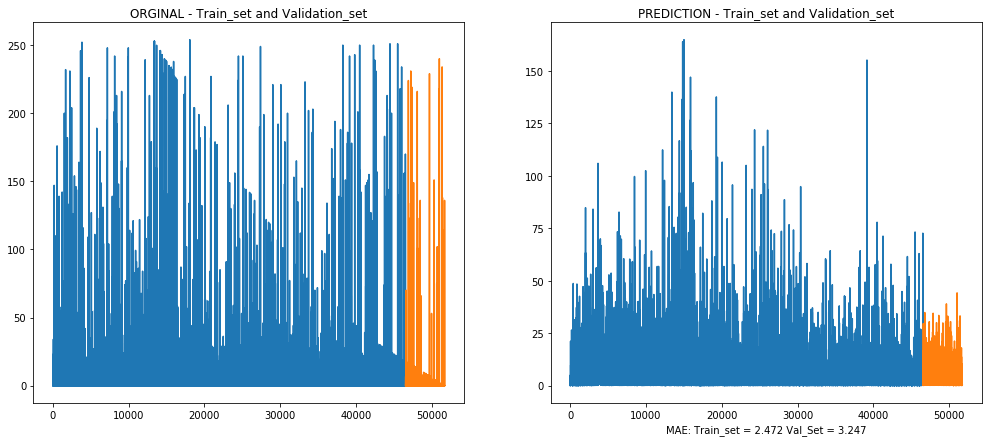

Mean Absolute Error on the Training_Set: 2.472
Mean Absolute Error on the Validation_Set: 3.247
HyperParameters of best regresor:

 RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=62,
                      max_features='sqrt', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=4, min_samples_split=4,
                      min_weight_fraction_leaf=0.0, n_estimators=2000,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)


In [145]:
best_grid = RF_random.best_estimator_
Summary(best_grid,10)

##### RandomForest Fine-Tuning

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   13.6s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    1.0s
[Parallel(n_jobs=12)]: Done 200 out of 200 | elapsed:    1.2s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 200 out of 200 | elapsed:    0.0s finished


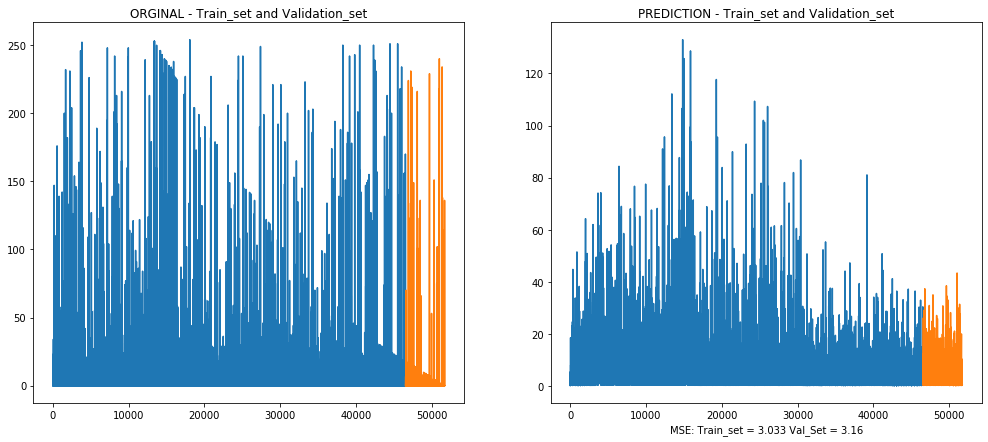

MSE on the Training_Set: 3.033
MSE on the Validation_Set: 3.16

HyperParameters of best regresor:
 RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=15,
                      max_features='log2', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=10, min_samples_split=10,
                      min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
                      oob_score=False, random_state=42, verbose=1,
                      warm_start=False)


In [57]:
#BAGGING
RF_bagging = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=15,
                                      max_features='log2', max_leaf_nodes=None,
                                      min_impurity_decrease=0.0, min_impurity_split=None,
                                      min_samples_leaf=10, min_samples_split=10,
                                      min_weight_fraction_leaf=0.0, n_estimators=200,
                                      n_jobs=-1, random_state=42,verbose=1)

RF_bagging.fit(X_train, Y_train)
Summary(RF_bagging,10,X_train,Y_train,X_val,Y_val)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   31.6s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished


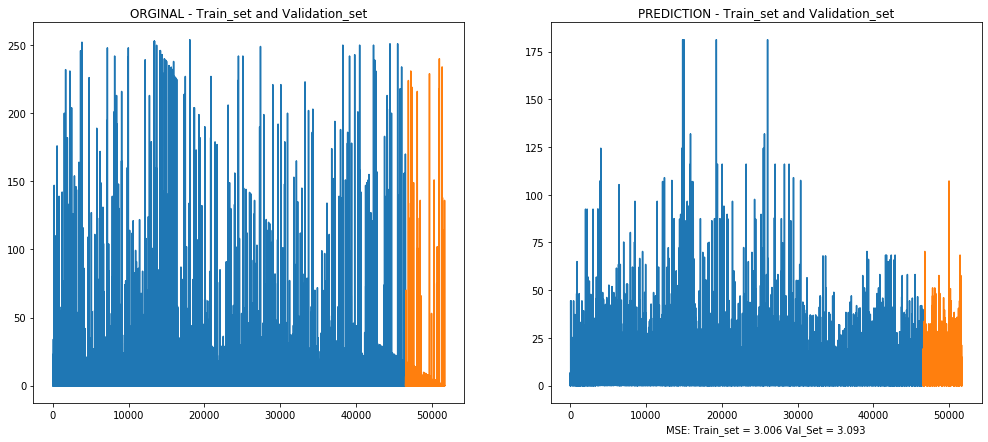

MSE on the Training_Set: 3.006
MSE on the Validation_Set: 3.093

HyperParameters of best regresor:
 RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=22, min_samples_split=38,
                      min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                      oob_score=False, random_state=42, verbose=1,
                      warm_start=False)


In [47]:
#BOOSTING
RF_boosting = RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=None,
                                      max_features=None, max_leaf_nodes=None,
                                      min_impurity_decrease=0.0, min_impurity_split=None,
                                      min_samples_leaf=22, min_samples_split=38,
                                      min_weight_fraction_leaf=0.0, n_estimators=100,
                                      n_jobs=-1, random_state=42,verbose=1)

RF_boosting.fit(X_train, Y_train)
Summary(RF_boosting,10,X_train,Y_train,X_val,Y_val)

##### Feature_importances

In [89]:
RF=pd.DataFrame(index=df.columns,data=RF_bagging.feature_importances_,columns=["Bagging"])
RF["Boosting"]=RF_boosting.feature_importances_.T
RF

,Bagging,Boosting
Quantity,0.028565,0.014656
UnitPrice,0.046583,0.034734
Country,0.001896,0.001327
Price*Quantity,0.063586,0.056985
Freq_stock,0.582430,0.575052
Freq_customer,0.066668,0.073109
Year,0.005631,0.003014
Month,0.062274,0.094677
Day,0.056078,0.059523
Hour,0.030912,0.033364


##### Summary
I decided to use random forests. It is a convenient tool for building quick models, used as proof of concept. At first, I have found a suboptimal solution using RandomizedSearchCV. This model achieves a good performance of MSE=2.472 on a training set and MSE=3.247 on a validation set. To reduce overfitting I tried two approaches.
<br>
First was bagging where the relatively bad model was trained many times on a subset of the training set. This regressor achieves MSE=3.03 on the training set and 3.16 on a test set. It performs better than the previous one but still, there is some overfitting.
<br>
Last was a simple boosting model - no bootstrap, no max_features, no max_depth. To control overfitting I used min_samples_leaf and min_samples_split. It was easy to computing since it has good performance with just 10 estimators at the beginning. 
Performance: train set MSE=3.006, Validation set 3.093 witches is the best result. 
<br>
Of course, this is not good results in objective terms and there is plenty of space to improve. For example, better feature engineering should give better results, since both models used Freq_stock as the main predictor.
